<a href="https://colab.research.google.com/github/GergelyTuri/fiberphotometry/blob/main/notebooks/calcium_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Calcum analysis
* 8/30/2023 setting up
* 9/2623 working on the fiberhot data class

In [ ]:
!git clone https://github.com/GergelyTuri/sleep.git
%cd sleep
!pip install .

Cloning into 'sleep'...
remote: Enumerating objects: 273, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 273 (delta 15), reused 20 (delta 8), pack-reused 242
Receiving objects: 100% (273/273), 1.08 MiB | 17.05 MiB/s, done.
Resolving deltas: 100% (141/141), done.
/content/sleep
Processing /content/sleep
  Preparing metadata (setup.py) ... done
  Created wheel for sleep: filename=sleep-0.1-py3-none-any.whl size=1000 sha256=9fa78b7b84912de5be4354ef08ff620ca4b53e5d3cb1bb46a8cde2d388f10f52
  Stored in directory: /tmp/pip-ephem-wheel-cache-mteffmmp/wheels/10/eb/42/5281370ac4a2d7b033087761ebaa8f968a9ef5108cbc009a46
Successfully built sleep


In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
!pip install tdt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 kB 1.9 MB/s eta 0:00:00


In [1]:
%matplotlib inline

In [12]:
# scripts for fiber photometry recordings.
# GT 2021

from dataclasses import dataclass

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from numpy.polynomial import Polynomial
from scipy.signal import medfilt, butter, filtfilt
from scipy.stats import linregress
from tdt import read_block

matplotlib.rcParams["font.size"] = 18  # set font size for all figures

# from bokeh.plotting import figure, show
# from bokeh.io import push_notebook, output_notebook
# output_notebook()


@dataclass
class FiberPhotometry:
    """Class for analyzing fiber photometry data.
    Initialize with the path to the TDT tank.
    Example:
    >>> tdt_tank = fp(tank_path="path/to/tank")
    >>> fp_data = tdt_tank.data"""

    tank_path: str
    # global variables
    DYNAMIC = str  # GCaMP channel (dynamic signal)
    ISOS = str  # Isobestic channel (static signal)

    def __post_init__(self):
        self.data = read_block(self.tank_path)
        self.DYNAMIC = "_465A"  # GCaMP channel (dynamic signal)
        self.ISOS = "_405A"

    @property
    def sampling_frequency(self):
        return data.streams["_465A"].fs

    def preprocess(self, signal: str):
        '''This function denoises GCaMP or ISOS signals
        with a median ad lowpass filter. Then it fits a 4th order
        polyonmial to the data subtracts the polyomial fit from the
        raw data.'''
        if signal == 'DYNAMIC':
            raw = data.streams[self.DYNAMIC]
        elif signal == "ISOS":
            raw = data.streams[self.ISOS]

        # Median and lowpass filter with filtfilt
        denoised_med = medfilt(raw.data, kernel_size=5)

        fs= self.sampling_frequency
        b,a = butter(2, 10, btype='low', fs=fs)
        denoised = filtfilt(b,a, denoised_med)

        # Fit 4th order polynomial to GCaMP signal and subtract
        coefs = np.polyfit(np.linspace(0, len(raw.data), num=len(raw.data)),
         denoised, deg=4)
        polyfit_data = np.polyval(coefs, np.linspace(0, len(raw.data), num=len(raw.data)))

        debleached = denoised - polyfit_data

        return debleached, denoised

    def correct_motion(self, GCaMP_prepro, ISOS_prepro):
        '''This function takes preprocessed GCaMP and Isosbestic
        sigals and finds the linear fit, then estimates the
        motion correction and substracts it from GCaMP.'''

        # find linear fit
        slope, intercept, r_value, p_value, std_err = linregress(x=ISOS_prepro, y=GCaMP_prepro)

        # estimate motion correction and subtract
        GCaMP_est_motion = intercept + slope * ISOS_prepro
        GCaMP_corrected = GCaMP_prepro - GCaMP_est_motion

        return GCaMP_corrected

    def deltaF_F(self, GCaMP_corrected, denoised):
        '''This function calculates the dF/F using the
        denoised data and the motion corrected.'''

        fs= self.sampling_frequency
        b,a = butter(2, 0.001, btype='low', fs=fs)
        baseline_fluorescence = filtfilt(b,a, denoised, padtype='even')

        GCaMP_dF_F = GCaMP_corrected/baseline_fluorescence

        return GCaMP_dF_F

    def yp_dfof(self, GCAMP_corrected, ISOS_prepro):
        x1 = GCAMP_corrected
        x2 = ISOS_prepro

        p_fitted = Polynomial(x2, x1, deg=1)
        return p_fitted
        # if p < 0:
        #     f0 = np.mean(x1)
        #     print('p<0')
        # else:
        #     f0 = p * (x2+reg)
        #     print('p>0')
        # dfof = 100*(x1-f0)/f0
        # return dfof
    # TODO: add a function to calculate dFF based on this.


    """
    YP's matlab code for dfof calculation
    x1=photData(1).data;
    x2=photData(2).data;
    reg = polyfit(x2,x1,1);
    disp(reg)
    if reg(1)<0
        f0=mean(x1);
    else
        f0=reg(1).*x2+reg(2);
    end
    delF=100.*(x1-f0)./f0;

    x1 and x2 are the two channels of data (465 and 405)
  """



In [13]:
tdt_tank = FiberPhotometry(tank_path='/gdrive/Shareddrives/Turi_lab/Data/fiber_photometry/test_recordings/1aflox22a_1-230819-160056/')
data = tdt_tank.data
data.info

Found Synapse note file: /gdrive/Shareddrives/Turi_lab/Data/fiber_photometry/test_recordings/1aflox22a_1-230819-160056/Notes.txt
read from t=0s to t=365.35s


tankpath:	'/gdrive/Shareddrives/Turi_lab/Data/fiber_photometry/test_recordings'
blockname:	'1aflox22a_1-230819-160056'
start_date:	datetime.datetime(2023, 8, 19, 20, 1, 0, 999999)
utc_start_time:	'20:01:00'
stop_date:	datetime.datetime(2023, 8, 19, 20, 7, 6, 345563)
utc_stop_time:	'20:07:06'
duration:	datetime.timedelta(seconds=365, microseconds=345564)
stream_channel:	0
snip_channel:	0
experiment:	'EEGFP1c'
subject:	'1aflox22a_1'
user:	'User'
start:	'4:01:01pm 08/19/2023'
stop:	'4:07:06pm 08/19/2023'

In [7]:
GCAMP_prepro, GCAMP_denoised = tdt_tank.preprocess(signal='DYNAMIC')
ISOS_prepro, ISOS_denoised = tdt_tank.preprocess(signal='ISOS')

In [8]:
GCAMP_corrected = tdt_tank.correct_motion(GCAMP_prepro, ISOS_prepro)
GCAMP_dfof = tdt_tank.deltaF_F(GCAMP_corrected, GCAMP_denoised)

In [87]:
x = GCAMP_corrected[500:]
y = np.linspace(0, len(x), num=len(x))


coeffs = np.polyfit(x,y,1)
new_y = np.polyval(coeffs, x)

dfof = 100*((new_y-np.mean(new_y))/np.mean(new_y))

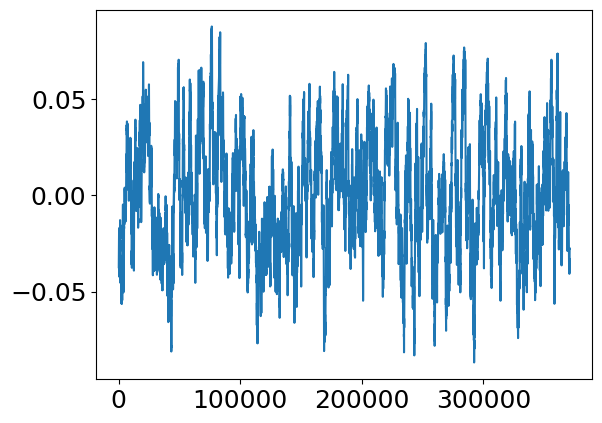

In [88]:
plt.plot(dfof)

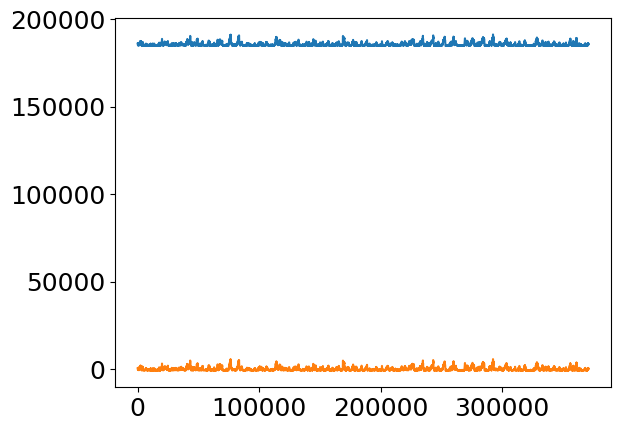

In [71]:
plt.plot(new_y)
plt.plot(new_y-np.mean(new_y))

In [14]:
dfof = tdt_tank.yp_dfof(tdt_tank.data.streams['_465A'].data[500:],
                        tdt_tank.data.streams['_405A'].data[500:])

TypeError: ignored

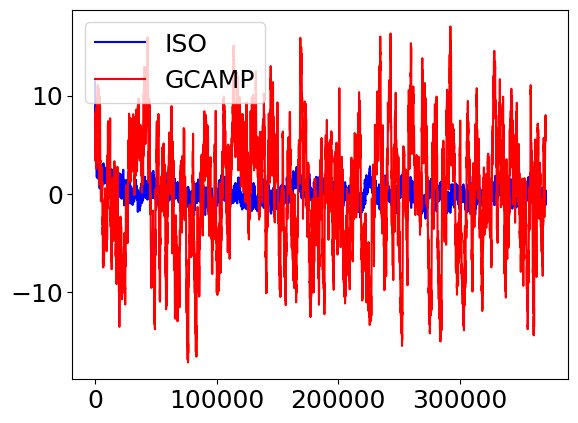

In [10]:
# plt.plot(GCAMP_prepro[500:], color='k')
plt.plot(ISOS_prepro[500:], color='b')
plt.plot(GCAMP_corrected[500:], color='r')
plt.legend(labels=['ISO', 'GCAMP'])

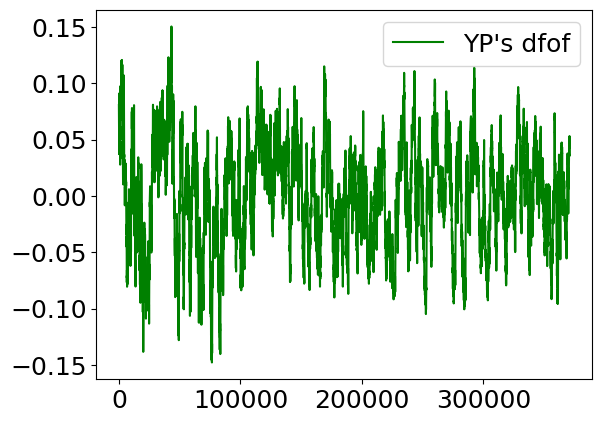

In [11]:
plt.plot(GCAMP_dfof[500:], color='g')
plt.legend(labels=["YP's dfof"])
# plt.plot(dfof)

In [ ]:
%cd ..

/content


In [ ]:
!git clone https://github.com/GergelyTuri/fiberphotometry.git
%cd fiberphotometry
!pip install .

In [ ]:
%cd /content/fiberphotometry/
!git pull

Does not work with the latest version (0.6.1)

In [ ]:
!pip install tdt #==0.5.9

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 1.6 MB/s eta 0:00:00


In [10]:
from os.path import join
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import medfilt, butter, filtfilt
from scipy.stats import linregress
import pandas as pd

import tdt
from sleep.base import core
import fiberphotometry.src.fiberphotometry as fp

%matplotlib inline

ModuleNotFoundError: ignored

In [ ]:
dr = core.GoogleDrive()
mnt = dr.mount_drive()

Mounted at /gdrive


source: https://github.com/MicTott/FiberFlow/blob/main/data_processing.py

In [ ]:
def preprocess(raw, time_seconds, fs):
    '''This function denoises GCaMP or ISOS signals
    with a median ad lowpass filter. Then it fits a 4th order
    polyonmial to the data subtracts the polyomial fit from the
    raw data.'''

    # Median and lowpass filter with filtfilt
    denoised_med = medfilt(raw, kernel_size=5)

    b,a = butter(2, 10, btype='low', fs=fs)
    denoised = filtfilt(b,a, denoised_med)

    # Fit 4th order polynomial to GCaMP signal and sutract
    coefs = np.polyfit(time_seconds, denoised, deg=4)
    polyfit_data = np.polyval(coefs, time_seconds)

    debleached = denoised - polyfit_data

    return debleached, denoised

def correct_motion(GCaMP_prepro, ISOS_prepro):
    '''This function takes preprocessed GCaMP and Isosbestic
    sigals and finds the linear fit, then estimates the
    motion correction and substracts it from GCaMP.'''

    # find linear fit
    slope, intercept, r_value, p_value, std_err = linregress(x=ISOS_prepro, y=GCaMP_prepro)

    # estimate motion correction and subtract
    GCaMP_est_motion = intercept + slope * ISOS_prepro
    GCaMP_corrected = GCaMP_prepro - GCaMP_est_motion

    return GCaMP_corrected

def deltaF_F(GCaMP_corrected, denoised, fs):
    '''This function calculates the dF/F using the
    denoised data and the motion corrected.'''

    b,a = butter(2, 0.001, btype='low', fs=fs)
    baseline_fluorescence = filtfilt(b,a, denoised, padtype='even')

    GCaMP_dF_F = GCaMP_corrected/baseline_fluorescence

    return GCaMP_dF_F

In [ ]:
tdt_path = '/gdrive/Shareddrives/Turi_lab/Data/fiber_photometry/test_recordings/1aflox22a_1-230819-160741'

# tdt_path = '/gdrive/Shareddrives/Turi_lab/Data/fiber_photometry/test_recordings/1aflox22a_1-230819-160056'

In [ ]:
data = tdt.read_block(tdt_path, evtype=['epocs', 'snips', 'streams'],
                      channel=1)
data

Found Synapse note file: /gdrive/Shareddrives/Turi_lab/Data/fiber_photometry/test_recordings/1aflox22a_1-230819-160741/Notes.txt
read from t=0s to t=301.95s


epocs	[struct]
snips	[struct]
streams	[struct]
scalars	[struct]
info	[struct]
time_ranges:	array([[ 0.],
       [inf]])

In [ ]:
res_data = fp.resample(data)

In [ ]:
no_art = fp.artifact_removal(data)
no_art

epocs	[struct]
snips	[struct]
streams	[struct]
scalars	[struct]
info	[struct]
time_ranges:	array([[ 0.],
       [inf]])

In [ ]:
detrended = fp.detrending(no_art)
detrended

<ipython-input-24-921d524052c8>:1: RankWarning: Polyfit may be poorly conditioned
  detrended = fp.detrending(no_art)


array([ 5.345049 ,  5.3795123,  5.412228 , ..., -9.011989 , -9.004134 ,
       -8.995619 ], dtype=float32)

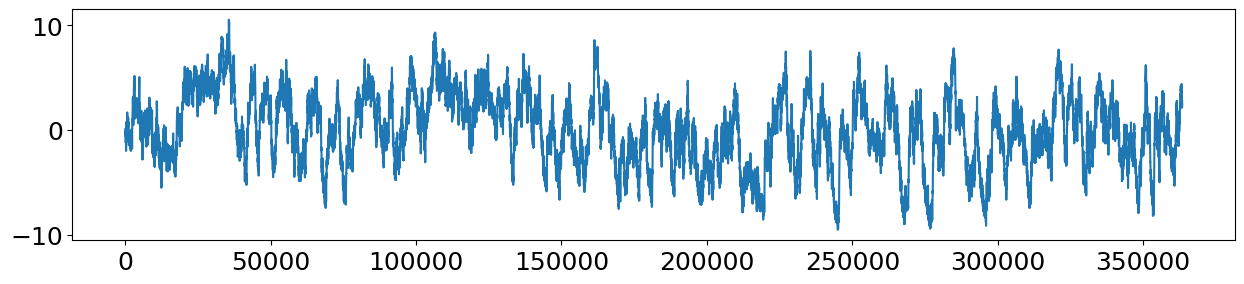

In [ ]:
fig = plt.figure(figsize=(15,3))
plt.plot(detrended)

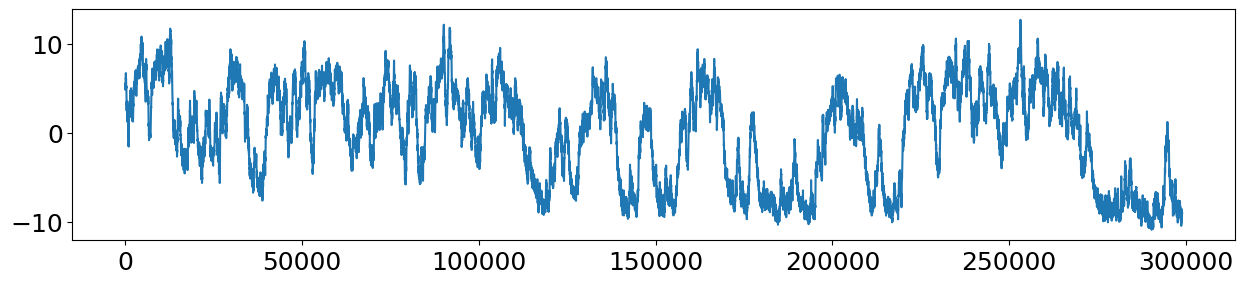

In [ ]:
fig = plt.figure(figsize=(15,3))
plt.plot(detrended)